<a href="https://colab.research.google.com/github/Manvi1718/Emotion_Analysis/blob/main/MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion analysis

## Connecting dataset with kaggle


In [2]:
import os
os.environ["KAGGLE_USERNAME"] = "annmittal"
os.environ["KAGGLE_KEY"] ="b36a820c483a21bd0633e9b284bbc42c"

!kaggle datasets download -d shawon10/ckplus

100% 3.63M/3.63M [00:01<00:00, 4.15MB/s]
100% 3.63M/3.63M [00:01<00:00, 3.05MB/s]


In [3]:
!unzip ckplus.zip

Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_00000024.png  
  inflating: CK+48/anger/S029_001_00000017.png  
  inflating: CK+48/anger/S029_001_00000018.png  

## Loading libraries

In [4]:
pip install split-folders

In [5]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#import albumentations
#from albumentations import pytorch as AT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import csv
from PIL import Image
import splitfolders
import os
from torchvision.datasets import ImageFolder
import zipfile

## Setup device agnostic code

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
'''#Splitting dataset into train ,test and validation

original="/content/drive/MyDrive/pytorch/ck+/CK+48"
splitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"

splitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)
'''

'#Splitting dataset into train ,test and validation\n\noriginal="/content/drive/MyDrive/pytorch/ck+/CK+48"\nsplitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"\n\nsplitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)\n'

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted'

/content/drive/MyDrive/pytorch/ck+/CK+48 splitted


In [11]:
# To unzip files
"""
#Extract Zip File
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
"""

"\n#Extract Zip File\nwith zipfile.ZipFile('train.zip', 'r') as zip_ref:\n    zip_ref.extractall('train')\n\nwith zipfile.ZipFile('test.zip', 'r') as zip_ref:\n    zip_ref.extractall('test')\n"

In [12]:
# Define transformations, including converting to grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale with 1 channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust mean and std for 1-channel grayscale
])

In [13]:
# Path to the root directory of your train and test data in Google Drive
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]

In [45]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label

In [46]:
# Load custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

In [47]:
# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
"""# Access labels in the train DataLoader
for images, labels in train_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Train Emotion Label: {emotion_label}")

# Access labels in the test DataLoader
for images, labels in test_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Test Emotion Label: {emotion_label}")
"""

'# Access labels in the train DataLoader\nfor images, labels in train_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Train Emotion Label: {emotion_label}")\n\n# Access labels in the test DataLoader\nfor images, labels in test_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Test Emotion Label: {emotion_label}")\n'

In [49]:
len(train_dataloader) , len(test_dataloader)

(23, 8)

In [50]:
len(train_dataset) , len(test_dataset)

(725, 248)

In [51]:
# see the first training example
image , label = train_dataset[0]
image , label

(tensor([[[1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          ...,
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536]]]),
 1)

In [52]:
class_names=emotion_labels
class_names

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [53]:
# Chcek the shape
print(f"image shape : {image.shape}")
print(f"image label : {class_names[label]}")

image shape : torch.Size([1, 224, 224])
image label : contempt


In [54]:
print(emotion_labels[3])

fear


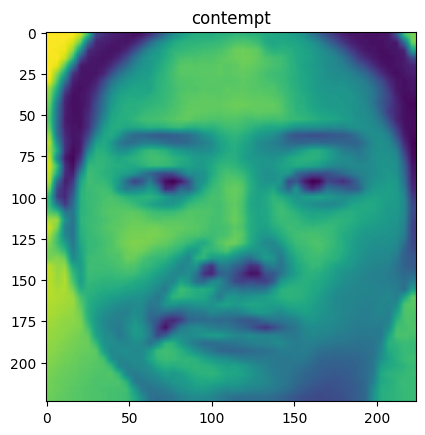

In [55]:
# Assuming your image is in the shape (3, 224, 224)
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(emotion_labels[label])
plt.show()


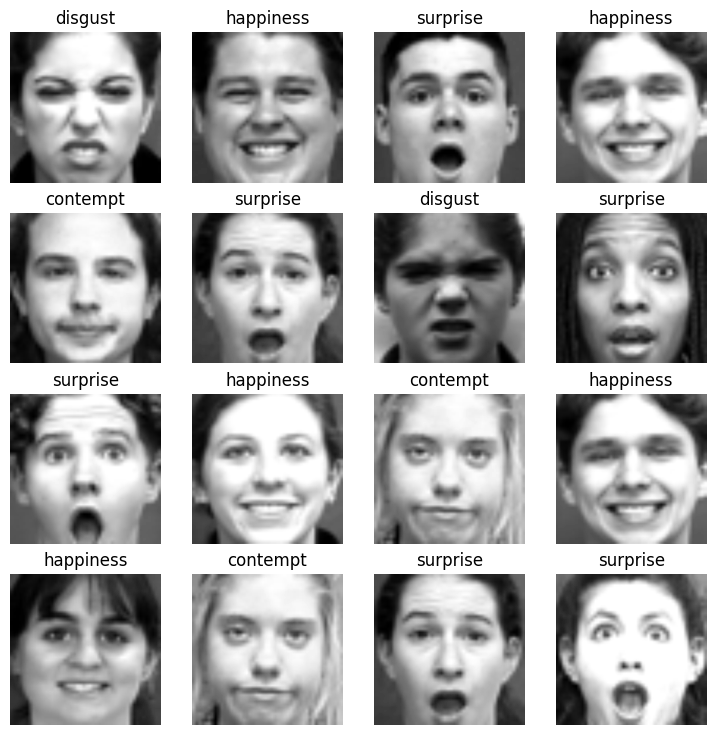

In [56]:
# plot more images
torch.manual_seed(42)
fig =plt.figure(figsize = (9,9))
rows , cols = 4,4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_dataset) , size =[1]).item()
  img , label = train_dataset[random_idx]
  fig.add_subplot(rows,cols , i)
  plt.imshow(img.squeeze() ,cmap="gray")
  plt.title(emotion_labels[label])
  plt.axis(False)

In [25]:
train_dataset , test_dataset

(<__main__.CustomDataset at 0x7f8d61b16e30>,
 <__main__.CustomDataset at 0x7f8d61b17d00>)

In [26]:

# Lets check out what we have created
print(f"dataloaders : {train_dataloader , test_dataloader}")
print(f" length of train_dataloader : {len(train_dataloader)} batches of {batch_size}....")
print(f" length of test_dataloader : {len(test_dataloader)} batches of {batch_size}...")

dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x7f8d61b17130>, <torch.utils.data.dataloader.DataLoader object at 0x7f8d61b162f0>)
 length of train_dataloader : 23 batches of 32....
 length of test_dataloader : 8 batches of 32...


In [27]:
# Check out whats inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 224, 224]), torch.Size([32]))

In [28]:
#Model using CNN Architechture

class CK48Model(nn.Module):
  #Blocks
  def __init__(self,input_shape,num_classes,hidden_units):                                ##input shape= 1 one color channel (grayscale for our image data)
    super().__init__()
    self.block_1=nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size=(3,3), stride=1, padding=1, bias = False),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=(3,3), stride=1, padding=1, bias = False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )

    self.block_2=nn.Sequential(
        nn.Conv2d(in_channels =hidden_units, out_channels = hidden_units, kernel_size=(3,3), stride=1, padding=1, bias = False),
        nn.ReLU(),
        nn.Conv2d(in_channels =hidden_units, out_channels = hidden_units, kernel_size=(3,3), stride=1, padding=1, bias = False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )

    self.classifeir=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=256*9*9,out_features=num_classes,bias = False)
    )

  def forward(self,x):
    x=self.block_1(x)
    x=self.block_2(x)
    x=self.classifeir(x)
    return x

In [29]:
#input shape= 1 ~ we have one color channel only
#num_classes= 7 ~ we have 7 catagories in our dataset(7 emotions)

## Model Building
model = CK48Model(input_shape=1,hidden_units=10, num_classes=len(class_names)).to(device)
model

CK48Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifeir): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20736, out_features=7, bias=False)
  )
)